Veri hazırlanıyor ve yeni özellikler ekleniyor...

En iyi model ayarları aranıyor... (Bu işlem biraz sürebilir)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

 EN İYİ PARAMETRELER: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
 YENİ MODEL DOĞRULUĞU: %58.52

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56        65
           1       0.59      0.63      0.61        70

    accuracy                           0.59       135
   macro avg       0.58      0.58      0.58       135
weighted avg       0.58      0.59      0.58       135

Confusion Matrix:
[[35 30]
 [26 44]]


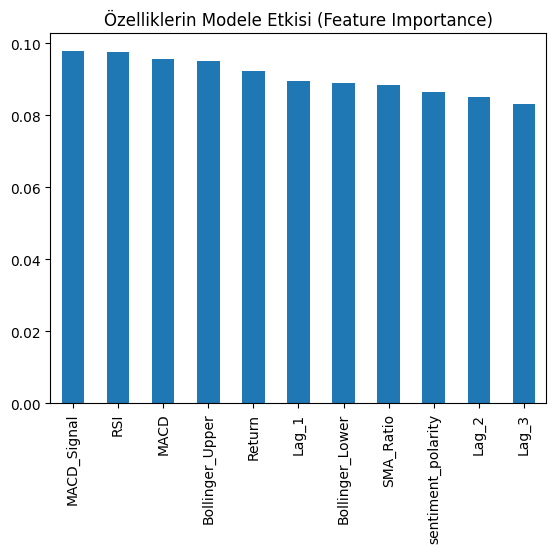

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------------------------------------
# ADIM 1: VERİYİ HAZIRLA
# ---------------------------------------------------------
file_path = 'AAPL_Filtered_2021_2024.csv'
print("Veri hazırlanıyor ve yeni özellikler ekleniyor...")

df_raw = pd.read_csv(file_path, sep=';')
df_raw.columns = df_raw.columns.str.strip()

# Finansal Veri
df_finance = df_raw.iloc[:, 0:7].copy()
df_finance.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df_finance['Date'] = pd.to_datetime(df_finance['Date'], format='%d.%m.%Y', errors='coerce')
df_finance.dropna(subset=['Date'], inplace=True)
df_finance.set_index('Date', inplace=True)
df_finance['Close'] = pd.to_numeric(df_finance['Close'], errors='coerce')

# Duygu Verisi
if len(df_raw.columns) > 8:
    df_sentiment = df_raw.iloc[:, 8:].copy()
    cols = list(df_sentiment.columns)
    cols[0] = 'Date'
    df_sentiment.columns = cols
    df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%d.%m.%Y', errors='coerce')
    df_sentiment.dropna(subset=['Date'], inplace=True)
    if 'sentiment_polarity' in df_sentiment.columns:
        df_sentiment['sentiment_polarity'] = pd.to_numeric(df_sentiment['sentiment_polarity'], errors='coerce')
        df_sentiment = df_sentiment.groupby('Date')['sentiment_polarity'].mean()
    else:
        df_sentiment = pd.DataFrame()
else:
    df_sentiment = pd.DataFrame()

# Birleştir
df_merged = df_finance.join(df_sentiment, how='left')
df_merged['sentiment_polarity'] = df_merged['sentiment_polarity'].fillna(0)

# ---------------------------------------------------------
# ADIM 2: GELİŞMİŞ ÖZELLİK MÜHENDİSLİĞİ (YENİLER EKLENDİ)
# ---------------------------------------------------------
# Temel Getiri
df_merged['Return'] = df_merged['Close'].pct_change()

# 1. MACD (Trend Takipçisi) - YENİ!
ema_12 = df_merged['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_merged['Close'].ewm(span=26, adjust=False).mean()
df_merged['MACD'] = ema_12 - ema_26
df_merged['MACD_Signal'] = df_merged['MACD'].ewm(span=9, adjust=False).mean()

# 2. Bollinger Bantları (Volatilite) - YENİ!
sma_20 = df_merged['Close'].rolling(window=20).mean()
std_20 = df_merged['Close'].rolling(window=20).std()
df_merged['Bollinger_Upper'] = (df_merged['Close'] - (sma_20 + 2*std_20)) / sma_20 # Normalize edilmiş
df_merged['Bollinger_Lower'] = (df_merged['Close'] - (sma_20 - 2*std_20)) / sma_20

# 3. RSI ve SMA Ratio (Eskiler)
delta = df_merged['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_merged['RSI'] = 100 - (100 / (1 + rs))
df_merged['SMA_Ratio'] = (df_merged['Close'] - sma_20) / sma_20

# 4. Hafıza (Lags) - Hafızayı 3 güne çıkardık
df_merged['Lag_1'] = df_merged['Return'].shift(1)
df_merged['Lag_2'] = df_merged['Return'].shift(2)
df_merged['Lag_3'] = df_merged['Return'].shift(3)

# 5. HEDEF
df_merged['Next_Close'] = df_merged['Close'].shift(-1)
df_merged['Target'] = (df_merged['Next_Close'] > df_merged['Close']).astype(int)

df_merged.dropna(inplace=True)

# Özellik Listesi
features = [
    'Return', 'Lag_1', 'Lag_2', 'Lag_3',
    'RSI', 'SMA_Ratio',
    'MACD', 'MACD_Signal',
    'Bollinger_Upper', 'Bollinger_Lower',
    'sentiment_polarity'
]

X = df_merged[features]
y = df_merged['Target']

# ---------------------------------------------------------
# ADIM 3: OTOMATİK HİPERPARAMETRE AYARI (GRID SEARCH)
# ---------------------------------------------------------
print("\nEn iyi model ayarları aranıyor... (Bu işlem biraz sürebilir)")

# Zaman serisi için özel bölücü (Geleceği görmemesi için)
tscv = TimeSeriesSplit(n_splits=5)

# Denenecek Parametreler
param_grid = {
    'n_estimators': [100, 200, 300],     # Ağaç sayısı
    'max_depth': [3, 4, 5],              # Derinlik (Çok derin ezberler)
    'learning_rate': [0.01, 0.05, 0.1],  # Öğrenme hızı
    'subsample': [0.8, 0.9],             # Veri çeşitliliği
    'colsample_bytree': [0.8, 1.0]       # Özellik çeşitliliği
}

xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Izgara Araması (En iyiyi bulur)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 # Tüm işlemci çekirdeklerini kullan
)

# Eğitim ve Test Ayrımı (Son %15 Test)
split = int(len(X) * 0.85)
X_train_full = X.iloc[:split]
y_train_full = y.iloc[:split]
X_test = X.iloc[split:]
y_test = y.iloc[split:]

# Aramayı Başlat
grid_search.fit(X_train_full, y_train_full)

# ---------------------------------------------------------
# ADIM 4: SONUÇLAR
# ---------------------------------------------------------
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
acc = accuracy_score(y_test, preds)

print(f"\n EN İYİ PARAMETRELER: {grid_search.best_params_}")
print(f" YENİ MODEL DOĞRULUĞU: %{acc * 100:.2f}")

print("\nDetaylı Rapor:")
print(classification_report(y_test, preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))

# Hangi özellik maçı kazandırdı?
import matplotlib.pyplot as plt
feature_imp = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
feature_imp.plot(kind='bar', title='Özelliklerin Modele Etkisi (Feature Importance)')
plt.show()

In [5]:
# 1. En Son Günün Verisini Al
# df_merged'in son satırı bugünün verisidir.
last_row = df_merged.iloc[[-1]][features] # features listesi eğitimdekiyle AYNI olmalı

print(f"\n--- TAHMİN ZAMANI ---")
print(f"Analiz Edilen Tarih: {last_row.index[0].date()}")
print(f"Kullanılan Veriler:\n{last_row}")

# 2. Tahmin Yap
prediction = best_model.predict(last_row)
probability = best_model.predict_proba(last_row)

# 3. Sonucu Yorumla
direction = "YÜKSELİŞ (AL)" if prediction[0] == 1 else "DÜŞÜŞ (SAT)"
confidence = probability[0][prediction[0]] * 100

print(f"\n MODELİN TAHMİNİ: {direction}")
print(f" Güven Oranı: %{confidence:.2f}")

if prediction[0] == 1:
    print(" Model, bir sonraki gün fiyatın bugünkünden YÜKSEK kapanacağını öngörüyor.")
else:
    print(" Model, bir sonraki gün fiyatın bugünkünden DÜŞÜK kapanacağını öngörüyor.")


--- TAHMİN ZAMANI ---
Analiz Edilen Tarih: 2024-02-23
Kullanılan Veriler:
              Return     Lag_1     Lag_2     Lag_3        RSI  SMA_Ratio  \
Date                                                                       
2024-02-23 -0.010034  0.011244  0.004186 -0.004114  40.280199  -0.020327   

                MACD  MACD_Signal  Bollinger_Upper  Bollinger_Lower  \
Date                                                                  
2024-02-23 -1.732956    -1.294995        -0.054307         0.013654   

            sentiment_polarity  
Date                            
2024-02-23             0.92625  

 MODELİN TAHMİNİ: YÜKSELİŞ (AL)
 Güven Oranı: %65.22
 Model, bir sonraki gün fiyatın bugünkünden YÜKSEK kapanacağını öngörüyor.


In [7]:
def manuel_tahmin(degisim_yuzdesi, sentiment_skoru, rsi_degeri=50, macd_durumu=0):
    """
    Modeli test etmek için manuel veri girişi sağlar.
    degisim_yuzdesi: Örn %2 artış için 0.02, %1 düşüş için -0.01
    sentiment_skoru: -1 (Çok Kötü) ile +1 (Çok İyi) arası
    """

    # Modelin beklediği formatta sahte bir veri satırı oluşturuyoruz
    # Diğer teknik verileri (Lag, Bollinger vb.) ortalama değerlerden varsayıyoruz
    input_data = pd.DataFrame({
        'Return': [degisim_yuzdesi],
        'Lag_1': [degisim_yuzdesi], # Dün de bugün gibiydi varsayalım
        'Lag_2': [0.01],
        'Lag_3': [-0.01],
        'RSI': [rsi_degeri],
        'SMA_Ratio': [0.01], # Fiyat ortalamanın biraz üstünde
        'MACD': [macd_durumu],
        'MACD_Signal': [macd_durumu * 0.9],
        'Bollinger_Upper': [0.05],
        'Bollinger_Lower': [-0.05],
        'sentiment_polarity': [sentiment_skoru]
    })

    # Sütun sırasını garantiye al (features listesine göre)
    input_data = input_data[features]

    pred = best_model.predict(input_data)[0]
    prob = best_model.predict_proba(input_data)[0][pred] * 100

    yon = "YÜKSELİŞ" if pred == 1 else "DÜŞÜŞ"
    print(f"Senaryo: %{degisim_yuzdesi*100} Değişim, Sentiment: {sentiment_skoru}")
    print(f"Tahmin -> {yon} (Güven: %{prob:.1f})\n")

# --- ÖRNEKLERİ DENE ---
print("--- SENARYO ANALİZLERİ ---")
# Senaryo 1: Fiyat %2 düştü ama haberler muhteşem (Sentiment 0.8)
manuel_tahmin(-0.02, 0.8, rsi_degeri=30)

# Senaryo 2: Fiyat %1 arttı ama haberler berbat (Sentiment -0.5)
manuel_tahmin(0.01, -0.5, rsi_degeri=70)

--- SENARYO ANALİZLERİ ---
Senaryo: %-2.0 Değişim, Sentiment: 0.8
Tahmin -> YÜKSELİŞ (Güven: %69.0)

Senaryo: %1.0 Değişim, Sentiment: -0.5
Tahmin -> YÜKSELİŞ (Güven: %70.6)



In [8]:
import joblib

joblib.dump(best_model, 'apple_tahmin_modeli_v1.pkl')
print("Model başarıyla kaydedildi: apple_tahmin_modeli_v1.pkl")

# --- YARIN NASIL KULLANACAKSIN? ---
# 2. Modeli Geri Yükle (Başka bir dosyada)
# yuklenen_model = joblib.load('apple_tahmin_modeli_v1.pkl')
# tahmin = yuklenen_model.predict(yeni_veri)

Model başarıyla kaydedildi: apple_tahmin_modeli_v1.pkl
